In [19]:
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils

In [20]:
image_data = np.load('../input/ocular-disease-detection-eanet/image_data_50.npy')
labels = np.load('../input/ocular-disease-detection-eanet/labels_50.npy')

In [21]:
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

In [23]:
y_train = np_utils.to_categorical(y_train, num_classes = 7)
y_test = np_utils.to_categorical(y_test, num_classes = 7)

In [24]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (11284, 50, 50, 3)
SHAPE OF TESTING IMAGE DATA : (2821, 50, 50, 3)
SHAPE OF TRAINING LABELS : (11284, 7)
SHAPE OF TESTING LABELS : (2821, 7)


In [25]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [26]:
num_classes = 7
input_shape = (50, 50, 3)

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 100
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 625


In [27]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [28]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


In [29]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [30]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [31]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x


In [32]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/100
71/71 [==============================] - 46s 504ms/step - loss: 1.7366 - accuracy: 0.3642 - top-5-accuracy: 0.9297 - val_loss: 1.7075 - val_accuracy: 0.3496 - val_top-5-accuracy: 0.9451
Epoch 2/100
71/71 [==============================] - 34s 479ms/step - loss: 1.5894 - accuracy: 0.4161 - top-5-accuracy: 0.9611 - val_loss: 1.7536 - val_accuracy: 0.3487 - val_top-5-accuracy: 0.9513
Epoch 3/100
71/71 [==============================] - 34s 479ms/step - loss: 1.5623 - accuracy: 0.4366 - top-5-accuracy: 0.9640 - val_loss: 1.7867 - val_accuracy: 0.3660 - val_top-5-accuracy: 0.9477
Epoch 4/100
71/71 [==============================] - 34s 480ms/step - loss: 1.5318 - accuracy: 0.4426 - top-5-accuracy: 0.9696 - val_loss: 1.7680 - val_accuracy: 0.3828 - val_top-5-accuracy: 0.9437
Epoch 5/100
71/71 [==============================] - 34s 479ms/step - loss: 1.5093 - accuracy: 0.4533 - top-5-accuracy: 0.9735 - val_loss: 1.5427 - val_accuracy: 0.4692 - val_top-5-accuracy: 0.9721
Epoch 6/10

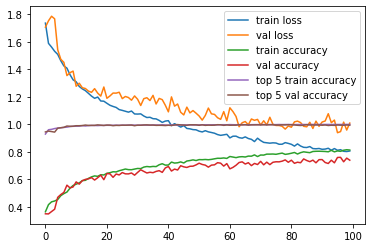

In [37]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['top-5-accuracy'], label='top 5 train accuracy')
plt.plot(history.history['val_top-5-accuracy'], label='top 5 val accuracy')
plt.legend()
plt.show()

In [ ]:
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()

In [41]:
y_pred = model.predict(x_test)

In [43]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
y_test_1 = y_test.argmax(axis=1)

In [48]:
y_pred_class

array([2, 2, 5, ..., 2, 1, 0])

In [49]:
y_test_1

array([2, 2, 5, ..., 2, 0, 0])

In [38]:
y_pred_class = y_pred.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

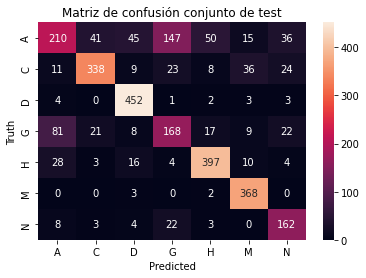

In [50]:
from sklearn.metrics import confusion_matrix

labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N']

cf_matrix = confusion_matrix(y_test_1, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9537471167283728
AP Score: 0.7998068852658295

              precision    recall  f1-score   support

           0       0.66      0.29      0.40       544
           1       0.88      0.73      0.80       449
           2       0.87      0.96      0.91       465
           3       0.50      0.40      0.44       326
           4       0.87      0.85      0.86       462
           5       0.85      0.99      0.91       373
           6       0.73      0.80      0.76       202

   micro avg       0.79      0.70      0.75      2821
   macro avg       0.76      0.72      0.73      2821
weighted avg       0.77      0.70      0.72      2821
 samples avg       0.70      0.70      0.70      2821



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_1,y_pred_class)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[210  41  45 147  50  15  36]
 [ 11 338   9  23   8  36  24]
 [  4   0 452   1   2   3   3]
 [ 81  21   8 168  17   9  22]
 [ 28   3  16   4 397  10   4]
 [  0   0   3   0   2 368   0]
 [  8   3   4  22   3   0 162]]
acc: 0.1943
sensitivity: 0.8367
specificity: 0.9685


In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.61      0.39      0.47       544
           C       0.83      0.75      0.79       449
           D       0.84      0.97      0.90       465
           G       0.46      0.52      0.49       326
           H       0.83      0.86      0.84       462
           M       0.83      0.99      0.90       373
           N       0.65      0.80      0.72       202

    accuracy                           0.74      2821
   macro avg       0.72      0.75      0.73      2821
weighted avg       0.74      0.74      0.73      2821



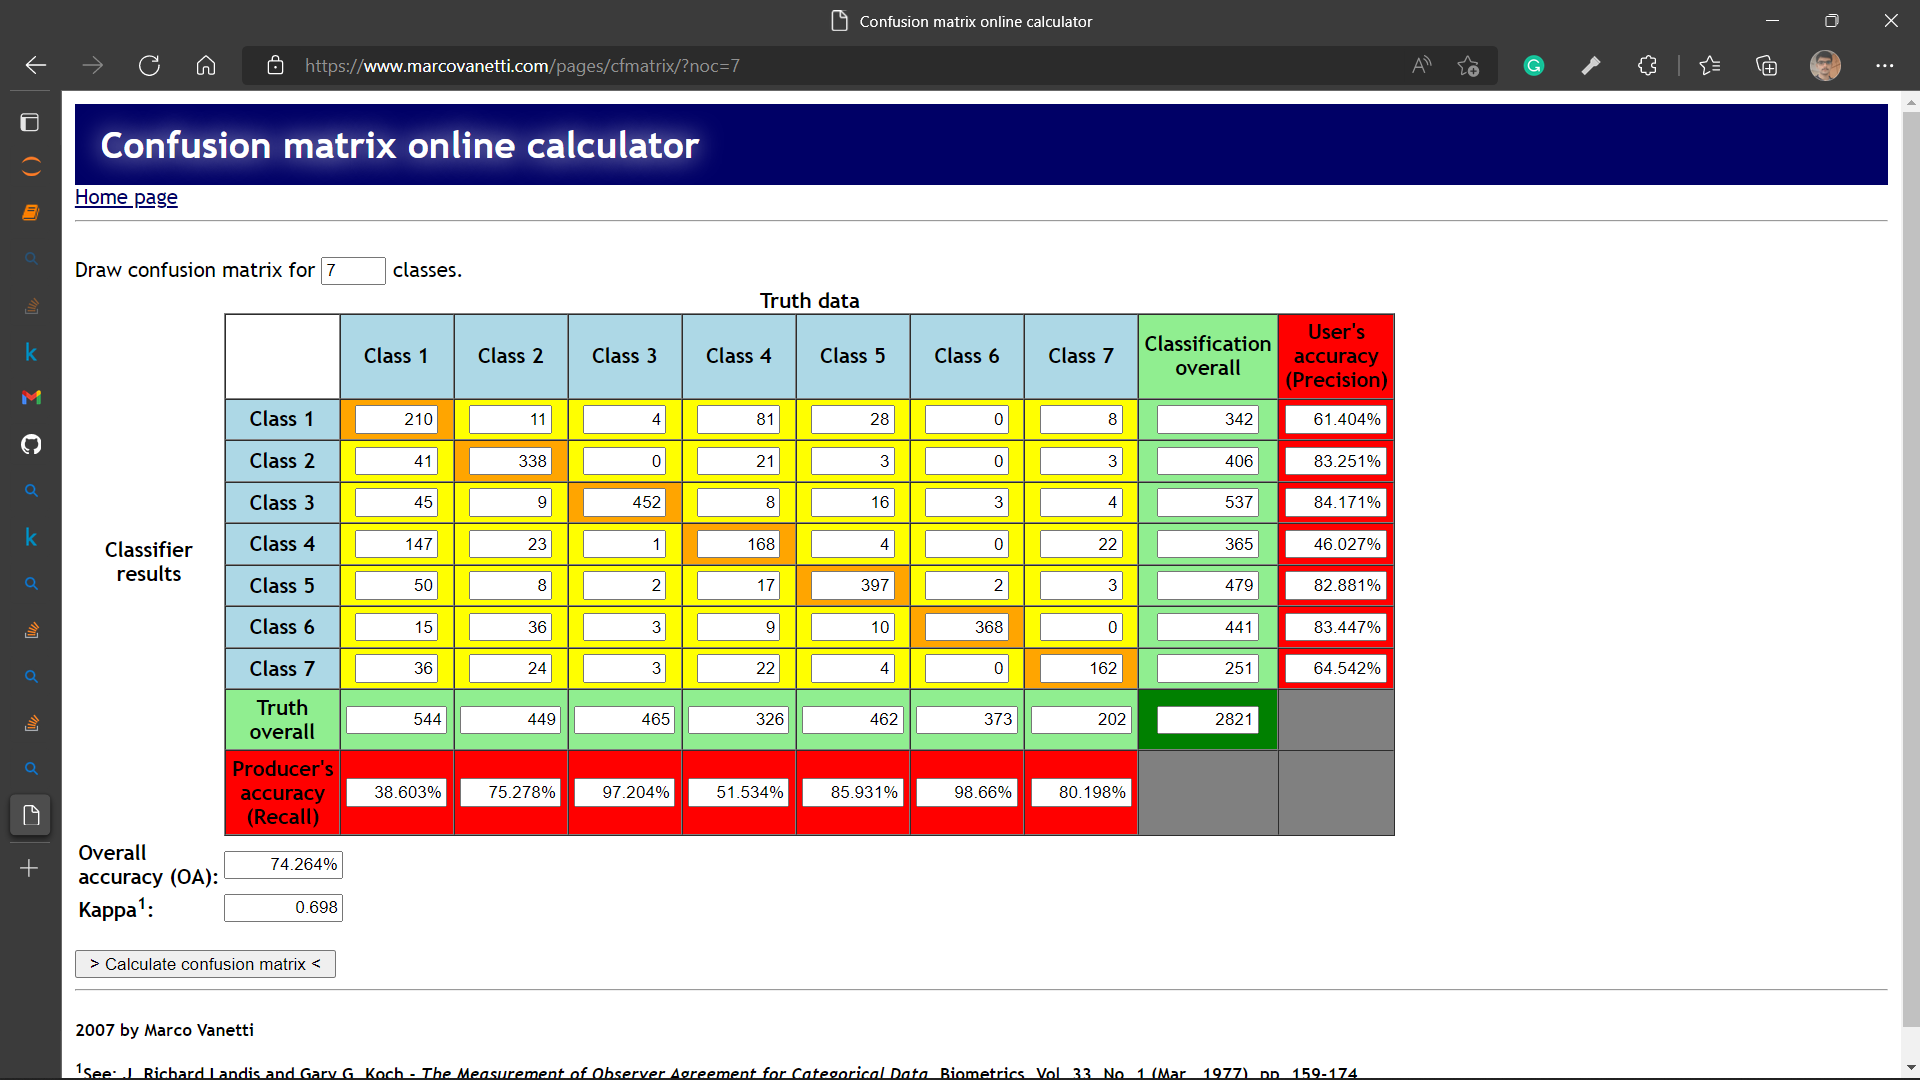